### Exploring Sentiment Classification using GloVe Word Embeddings and Deep Learning Models
#### Large Movie Reviews Data used for analysis comes from http://ai.stanford.edu/~amaas/data/sentiment/


By: Fawad Kirmani

Last Edited On: 11/10/2020

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional, MaxPooling1D, LeakyReLU, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report 

/home/fkirmani/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Choose between "CNN", "LSTM", "AUTOENCODER" and "BIDIRECTIONAL"

In [2]:
CHOOSE_MODEL = "BIDIRECTIONAL"

In [66]:
if CHOOSE_MODEL == "CNN":
    learn_rate = 1e-3
elif CHOOSE_MODEL == "LSTM":
    learn_rate = 1e-3
elif CHOOSE_MODEL == "AUTOENCODER":
    learn_rate = 2e-3
elif CHOOSE_MODEL == "BIDIRECTIONAL":
    learn_rate = 3e-2
loss = 'binary_crossentropy'
thresholds = 1200
roc_auc = tf.keras.metrics.AUC(num_thresholds=thresholds, curve='ROC', summation_method='interpolation')
metrtics_calc=[roc_auc, 'accuracy']

In [4]:
num_filters = 16
filter_size = 3
pool_size = 2
dropout_rate = 0.50
dense_layers = 128

#### Paths of input files

In [5]:
pos_train_file = "./aclImdb_v1/aclImdb/train/pos/"
neg_train_file = "./aclImdb_v1/aclImdb/train/neg/"
pos_test_file = "./aclImdb_v1/aclImdb/test/pos/"
neg_test_file = "./aclImdb_v1/aclImdb/test/neg/"

In [6]:
input_files = [pos_train_file, neg_train_file, pos_test_file, neg_test_file]

#### Importing data

In [7]:
def import_data(filename):
    file_list = glob.glob(os.path.join(os.getcwd(), filename, "*.txt"))

    input_data = []

    for file_path in file_list:
        with open(file_path) as f_input:
            input_data.append(f_input.read())
    return input_data

In [8]:
def overall_data(input_files):
    data = pd.DataFrame()
    for i in range(len(input_files)):
        df = pd.DataFrame(import_data(filename=input_files[i]), columns = ["reviews"])
        if input_files[i].find("/pos") > 0:
            df["label"] = 1
        else:
            df["label"] = 0
        if input_files[i].find("/train") > 0:
            df["data_type"] = "train"
        else:
            df["data_type"] = "test"
        data = data.append(df)
    data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data.dropna(axis=0,inplace=True)
    return data

In [9]:
data = overall_data(input_files=input_files)

#### I have followed the following online tutorial to learn GloVe Word Embeddings and process the data. 
https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

In [10]:
def preprocess_text(rev):
    # Removing html tags
    sentence = remove_tags(rev)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [12]:
X = []
sentences = list(data['reviews'])
for rev in sentences:
    X.append(preprocess_text(rev))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.10, random_state=80)

In [14]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
from numpy import array
from numpy import asarray
from numpy import zeros

#### Download glove.840B.300d.txt file from https://nlp.stanford.edu/projects/glove/

In [17]:
embeddings_dictionary = dict()
glove_file = open('../../project-data/glove.840B.300d.txt', 'r', errors = 'ignore', encoding='utf-8')

for line in glove_file:
    records = line.split(' ')
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [67]:
def optimizer_func(learn_rate):
    if CHOOSE_MODEL == "CNN":
        opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
    elif CHOOSE_MODEL == "LSTM":
        opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
    elif CHOOSE_MODEL == "AUTOENCODER":
        opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    elif CHOOSE_MODEL == "BIDIRECTIONAL":
        opt = tf.keras.optimizers.RMSprop(learning_rate=learn_rate)
    return opt

Embedding Layer

In [68]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], 
                            input_length=maxlen , trainable=False)

CNN Model

In [69]:
def cnn_func(num_filters, filter_size, pool_size, dense_layers, dropout_rate):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)

    # The first convolutional layer of the model with 16 filters and kernel of 3x3
    cnn_model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation="tanh"))
    cnn_model.add(MaxPooling1D(pool_size=pool_size))
    cnn_model.add(LeakyReLU())
    cnn_model.add(Dropout(dropout_rate))
    # The second convolutional layer of the model with 32 filters and kernel of 3x3
    cnn_model.add(Conv1D(filters=num_filters*2, kernel_size=3, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=pool_size))
    cnn_model.add(LeakyReLU())
    cnn_model.add(Dropout(dropout_rate))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(dense_layers, activation='tanh'))
    cnn_model.add(Dropout(int(dropout_rate*1.5)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(LeakyReLU())
    cnn_model.add(Dense(int(dense_layers/4), activation='tanh'))
    cnn_model.add(Dropout(int(dropout_rate*1.5)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(LeakyReLU())
    cnn_model.add(Dense(1, activation='sigmoid'))
    
    return cnn_model

LSTM Model

In [70]:
def lstm_func(num_filters):
    lstm_model = Sequential()
    lstm_model.add(embedding_layer)

    lstm_model.add(LSTM(int(num_filters/4), activation="tanh", return_sequences=True))
    lstm_model.add(LSTM(int(num_filters/2), activation="tanh"))
    lstm_model.add(Dense(1, activation='sigmoid'))
    
    return lstm_model

Autoencoder LSTM Model

In [71]:
def autoencoder_lstm_func(num_filters):
    autoencoder_lstm = Sequential()

    autoencoder_lstm.add(embedding_layer)

    autoencoder_lstm.add(LSTM(int(num_filters/4), activation="tanh", return_sequences=True))
    autoencoder_lstm.add(Flatten())
    autoencoder_lstm.add(RepeatVector((5)))
    autoencoder_lstm.add(LSTM(int(num_filters/2), activation="tanh", return_sequences=True))
    autoencoder_lstm.add(TimeDistributed(Dense(1)))
    autoencoder_lstm.add(Flatten())
    autoencoder_lstm.add(Dense(1, activation='sigmoid'))
    
    return autoencoder_lstm

Bidirectional LSTM Model

In [72]:
def bidirectional_func(num_filters):
    bidirectional_model = Sequential()
    bidirectional_model.add(embedding_layer)

    bidirectional_model.add(Bidirectional(LSTM(int(num_filters/4), return_sequences=True)))
    bidirectional_model.add(Bidirectional(LSTM(int(num_filters/8))))
    bidirectional_model.add(Dense(1, activation='sigmoid'))
    
    return bidirectional_model

Compiling the seleted model

In [73]:
def model_compile(model):
    compiled_model = model.compile(optimizer=optimizer_func(learn_rate), loss=loss, metrics=metrtics_calc)
    return compiled_model

In [74]:
if CHOOSE_MODEL == "CNN":
    model = cnn_func(num_filters, filter_size, pool_size, dense_layers, dropout_rate)
elif CHOOSE_MODEL == "LSTM":
    model = lstm_func(num_filters)
elif CHOOSE_MODEL == "AUTOENCODER":
    model = autoencoder_lstm_func(num_filters)
elif CHOOSE_MODEL == "BIDIRECTIONAL":
    model = bidirectional_func(num_filters)
model_compile(model)

Model Summary

In [76]:
print("                   Bidirectional LSTM Model Summary")
print(model.summary())

                   Bidirectional LSTM Model Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          29147100  
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 8)            9760      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4)                 176       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 29,157,041
Trainable params: 9,941
Non-trainable params: 29,147,100
_________________________________________________________________
None


Fitting the chosen model

In [28]:
if CHOOSE_MODEL == "CNN":
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('../project-data/saved_model/best_cnn_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1, callbacks=[es, mc])
elif CHOOSE_MODEL == "LSTM":
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('../project-data/saved_model/best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1, callbacks=[es, mc])
elif CHOOSE_MODEL == "AUTOENCODER":
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    mc = ModelCheckpoint('../project-data/saved_model/best_autoencoder_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.1, callbacks=[es, mc])
elif CHOOSE_MODEL == "BIDIRECTIONAL":
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('../project-data/saved_model/best_bidirectional_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    history = model.fit(X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_split=0.1, callbacks=[es, mc])

Epoch 1/10
1266/1266 [==============================] - 252s 199ms/step - loss: 0.3530 - auc: 0.9232 - accuracy: 0.8425 - val_loss: 0.2700 - val_auc: 0.9573 - val_accuracy: 0.8829
Epoch 2/10
1266/1266 [==============================] - 245s 193ms/step - loss: 0.2759 - auc: 0.9535 - accuracy: 0.8838 - val_loss: 0.2607 - val_auc: 0.9589 - val_accuracy: 0.8853
Epoch 3/10
1266/1266 [==============================] - 243s 192ms/step - loss: 0.2472 - auc: 0.9628 - accuracy: 0.8975 - val_loss: 0.2613 - val_auc: 0.9606 - val_accuracy: 0.8864
Epoch 4/10
1266/1266 [==============================] - 241s 190ms/step - loss: 0.2208 - auc: 0.9703 - accuracy: 0.9078 - val_loss: 0.2742 - val_auc: 0.9554 - val_accuracy: 0.8862
Epoch 5/10
1266/1266 [==============================] - 244s 193ms/step - loss: 0.1923 - auc: 0.9774 - accuracy: 0.9209 - val_loss: 0.2884 - val_auc: 0.9515 - val_accuracy: 0.8851
Epoch 00005: early stopping


In [39]:
# if CHOOSE_MODEL == "CNN":
#     history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)
# elif CHOOSE_MODEL == "LSTM":
#     history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1)
# elif CHOOSE_MODEL == "AUTOENCODER":
#     history = model.fit(X_train, y_train, batch_size=32, epochs=25, verbose=1, validation_split=0.1)
# elif CHOOSE_MODEL == "BIDIRECTIONAL":
#     history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1)

Accuracy vs Epoch plot of the chosen model

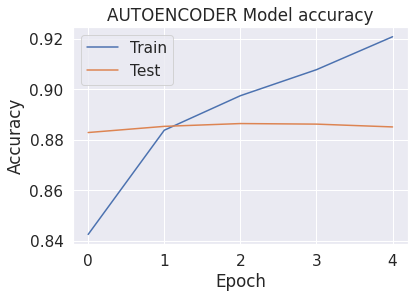

In [40]:
if CHOOSE_MODEL == "CNN":
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(CHOOSE_MODEL + ' Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_accuracy.png', dpi=300)
    plt.show()
elif CHOOSE_MODEL == "LSTM":
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(CHOOSE_MODEL + ' Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_accuracy.png', dpi=300)
    plt.show()
elif CHOOSE_MODEL == "AUTOENCODER":
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(CHOOSE_MODEL + ' Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_accuracy.png', dpi=300)
    plt.show()
elif CHOOSE_MODEL == "BIDIRECTIONAL":
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(CHOOSE_MODEL + ' Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_accuracy.png', dpi=300)
    plt.show()

Loss vs Epoch plot of the chosen model

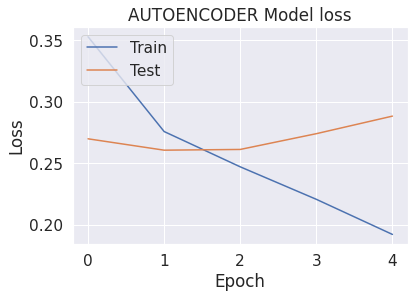

In [41]:
if CHOOSE_MODEL == "CNN":
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(CHOOSE_MODEL + ' Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_loss.png', dpi=300)
    plt.show()
elif CHOOSE_MODEL == "LSTM":
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(CHOOSE_MODEL + ' Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_loss.png', dpi=300)
    plt.show()
elif CHOOSE_MODEL == "AUTOENCODER":
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(CHOOSE_MODEL + ' Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_loss.png', dpi=300)
    plt.show()
elif CHOOSE_MODEL == "BIDIRECTIONAL":
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(CHOOSE_MODEL + ' Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./figures/' + CHOOSE_MODEL + '_model_loss.png', dpi=300)
    plt.show()

Loading the saved model

In [3]:
if CHOOSE_MODEL == "CNN":
    saved_model = load_model('../../project-data/saved_model/best_cnn_model.h5')
elif CHOOSE_MODEL == "LSTM":
    saved_model = load_model('../../project-data/saved_model/best_lstm_model.h5')
elif CHOOSE_MODEL == "AUTOENCODER":
    saved_model = load_model('../../project-data/saved_model/best_autoencoder_model.h5')
elif CHOOSE_MODEL == "BIDIRECTIONAL":
    saved_model = load_model('../../project-data/saved_model/best_bidirectional_model.h5')

#### Evaluating the Model

In [ ]:
print('\n# Evaluate on test data')
results = saved_model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = saved_model.predict(X_test[:3])
print('predictions shape:', predictions.shape)

In [170]:
model_pred = saved_model.predict(X_test, batch_size=128, verbose=1)
# model_predicted = np.argmax(model_pred, axis=0)

40/40 [==============================] - 4s 103ms/step


In [171]:
model_cm = confusion_matrix(y_test, model_pred.round()) 
model_cm

array([[2275,  276],
       [ 287, 2162]])

#### Confusion Matrix Heat Map

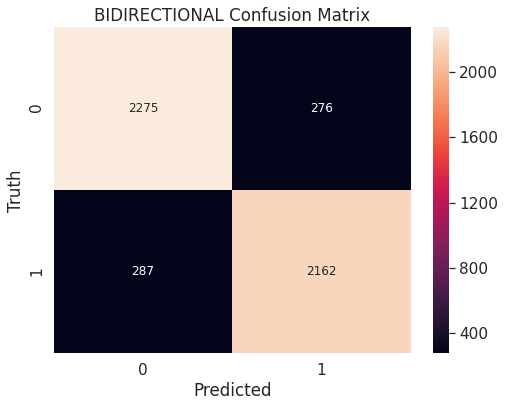

In [172]:
model_df_cm = pd.DataFrame(model_cm, range(2), range(2)) 
plt.figure(figsize = (8, 6)) 
plt.title(CHOOSE_MODEL + ' Confusion Matrix')
sn.set(font_scale=1.4) #for label size 
sn.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}, fmt="d") # font size 
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.savefig('./figures/' + CHOOSE_MODEL + '_confusion_matrix.png', dpi=300)
plt.show()

#### Normalized Confusion Matrix Heat Map

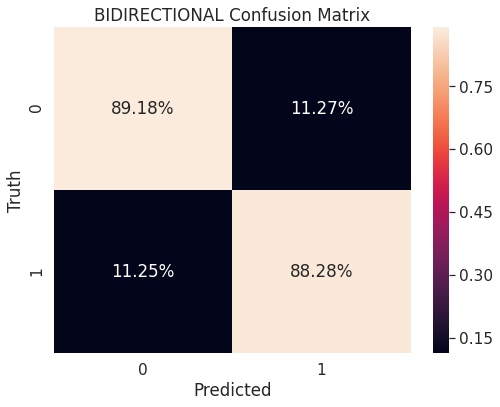

In [173]:
model_df_cm = pd.DataFrame(model_cm, range(2), range(2)) 
plt.figure(figsize = (8, 6)) 
plt.title(CHOOSE_MODEL + ' Confusion Matrix')
sn.set(font_scale=1.4) #for label size 
sn.heatmap(model_df_cm/np.sum(model_df_cm, 1), annot=True, fmt='.2%')
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.savefig('./figures/' + CHOOSE_MODEL + '_confusion_matrix_normalized.png', dpi=300)
plt.show()

#### Classification Report of the Model

In [174]:
model_report = classification_report(y_test, model_pred.round())
print(model_report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2551
           1       0.89      0.88      0.88      2449

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

